# Notebook: Modélisation

---
## Mise en place

Librairies et paramétrages utilisés au long de ce notebook

In [1]:
import pickle
import numpy as np
import pandas as pd
from transform_data import transform_data

# Visualization tools
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.colors import hex2color
from IPython.display import display
from Classification_results import Classification_Results

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples

In [2]:
%matplotlib inline
sns.set_context("notebook")

# Colors to be used throughout the notebook for each cluster
hex_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71"]
rbg_colors = [(*hex2color(color), 1.0) for color in hex_colors]

Chargeons les tables de données utiles

In [3]:
purchases = pd.read_feather('data/purchases')
data = pd.read_feather('data/features').set_index('CustomerID')

data.head()

,is_UK,Products_unique,Prods_per_invoice,Unit_avg,Spending_total,Spending_avg,N_cancelled,N_transactions,N_months,Timebtw_inv,First_unique,First_spending,First_units
CustomerID,,,,,,,,,,,,,
12346,1,1,0.00,1.04,0.00,0.00,1,2,1,90.000000,1,77183.60,1.04
12347,0,100,28.50,2.44,4085.18,680.86,0,6,6,0.015249,31,711.79,2.89
12348,0,22,6.75,2.16,1797.24,449.31,0,4,4,0.010610,13,892.80,2.92
12349,0,73,73.00,8.29,1757.55,1757.55,0,1,1,0.000000,73,1757.55,8.29
12350,0,17,17.00,3.84,334.40,334.40,0,1,1,0.000000,17,334.40,3.84


---
## Segmentation des clients par _clustering_

Dans un premier temps nous allons segmenter notre base client en clusters les plus cohérents possibles pour ensuite essayer de discener des habitudes d'achats propres à chacun de ces groupes

### Groupement des individus

Avant de passer à l'algorithme de clustering en lui même, nous passons par une phase de prétraitement de données: afin que tous les descripteurs aient la même importance dans l'étape de clustering, nous faisons en sorte qu'ils aient la même étendue, dans un intervalle de `[0, 1]`. En effet, les notions de ces distances sont essentielles à ce type d'algorithmes.

In [4]:
scaler = MinMaxScaler()
processed = scaler.fit_transform(data)

Utilisons l'algorithme t-SNE afin d'avoir une première idée du nombre de groupes homogènes que nous pourrions dégager sur tous les individus que nous possédons.

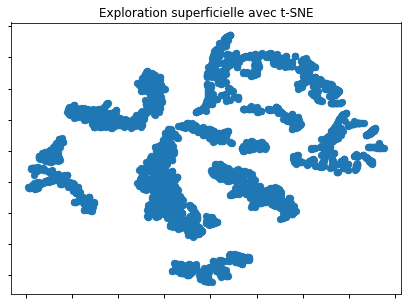

In [5]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(processed)

fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.scatter(Y[:, 0], Y[:, 1])
ax.set_title("Exploration superficielle avec t-SNE")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter());

Pour dégager des groupes cohérents d'individus de notre base, nous utilisons l'algorithme `K-Means`. Après plusieurs essais, en correspondance avec certains critères lors de la construction de groupes, nous avons choisis d'en établir 5. Parmi ces préoccupations nous devions:
- nous assurer que tous les groupes possédaient assez d'individus
- que nous ayons un nombre de groupes correspondant à un des meilleurs scores de silhouette. 

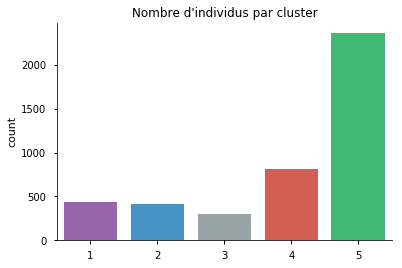

In [6]:
# Compute clustering on standardized data
n_clusters = 5
clustering = KMeans(n_clusters=n_clusters, n_init=100, max_iter=1e5, 
                    n_jobs=-1, random_state=0)
clustering.fit(processed)


labels = clustering.labels_ + 1
cluster_labels, counts = np.unique(labels, return_counts=True)


# Display bars
sns.countplot(labels, palette=rbg_colors)
plt.title("Nombre d'individus par cluster")
sns.despine()

### Description des groupements

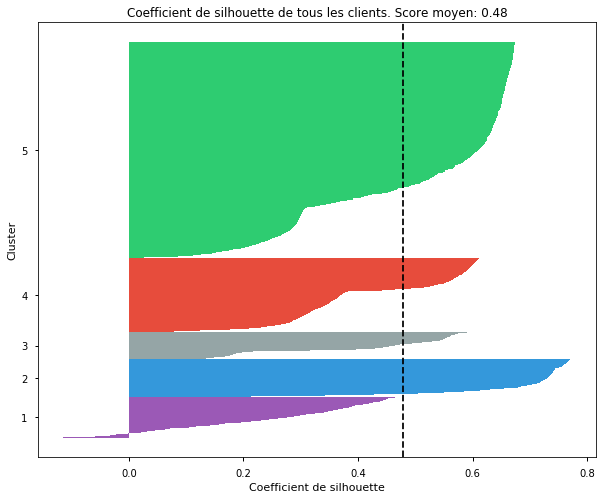

In [7]:
# Prepare
silhouette_vals = silhouette_samples(processed, labels, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []

# Compute
plt.subplots(1,1, figsize=(10, 8))
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = rbg_colors[i]
    #color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_score = np.mean(silhouette_vals)

# Display 
plt.axvline(silhouette_score,
            color="black",
            linestyle="--") 
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Coefficient de silhouette')
plt.title('Coefficient de silhouette de tous les clients. Score moyen: ' \
          + str(round(silhouette_score, 2)));

Description statistique tabulaire des différents clusters, par la moyenne et l'écart-type de chaque attribut

In [8]:
for i in range(n_clusters):
    mask = (labels == (i+1))
    print(f'\n\nCluster {i+1}: {counts[i]} individus')
    display(data[mask].describe().round(1).iloc[[1, 2], :])



Cluster 1: 441 individus


,is_UK,Products_unique,Prods_per_invoice,Unit_avg,Spending_total,Spending_avg,N_cancelled,N_transactions,N_months,Timebtw_inv,First_unique,First_spending,First_units
mean,1.0,104.1,52.9,2.7,1119.8,453.7,0.7,2.4,1.8,8.6,63.3,563.2,2.6
std,0.0,82.5,22.3,1.5,2488.8,301.0,2.1,2.2,1.0,75.6,27.8,442.2,0.9




Cluster 2: 415 individus


,is_UK,Products_unique,Prods_per_invoice,Unit_avg,Spending_total,Spending_avg,N_cancelled,N_transactions,N_months,Timebtw_inv,First_unique,First_spending,First_units
mean,0.0,67.9,20.7,7.0,3584.6,537.5,3.1,5.4,3.1,3.0,27.4,669.7,7.2
std,0.0,112.5,20.2,55.2,16758.3,687.7,13.8,13.5,2.6,38.0,27.6,950.1,55.6




Cluster 3: 301 individus


,is_UK,Products_unique,Prods_per_invoice,Unit_avg,Spending_total,Spending_avg,N_cancelled,N_transactions,N_months,Timebtw_inv,First_unique,First_spending,First_units
mean,1.0,174.2,15.8,4.0,10038.1,383.1,9.9,23.4,9.7,0.1,19.9,511.2,4.4
std,0.0,165.7,11.1,12.1,20236.1,396.8,16.7,21.1,1.5,0.1,19.6,781.9,16.3




Cluster 4: 813 individus


,is_UK,Products_unique,Prods_per_invoice,Unit_avg,Spending_total,Spending_avg,N_cancelled,N_transactions,N_months,Timebtw_inv,First_unique,First_spending,First_units
mean,1.0,90.1,16.9,3.7,2126.9,296.0,2.9,7.3,5.1,0.0,20.2,366.0,4.1
std,0.0,69.7,12.9,8.6,2278.8,224.4,5.9,3.0,1.0,0.0,16.9,415.6,11.9




Cluster 5: 2361 individus


,is_UK,Products_unique,Prods_per_invoice,Unit_avg,Spending_total,Spending_avg,N_cancelled,N_transactions,N_months,Timebtw_inv,First_unique,First_spending,First_units
mean,1.0,25.2,13.2,13.3,519.0,250.9,0.7,2.1,1.6,10.5,14.9,321.8,8.0
std,0.0,22.8,9.3,291.0,752.4,278.2,2.3,1.6,0.8,98.2,10.2,1638.7,104.7


Description statistique visuelle des différents clusters sur des variables choisies

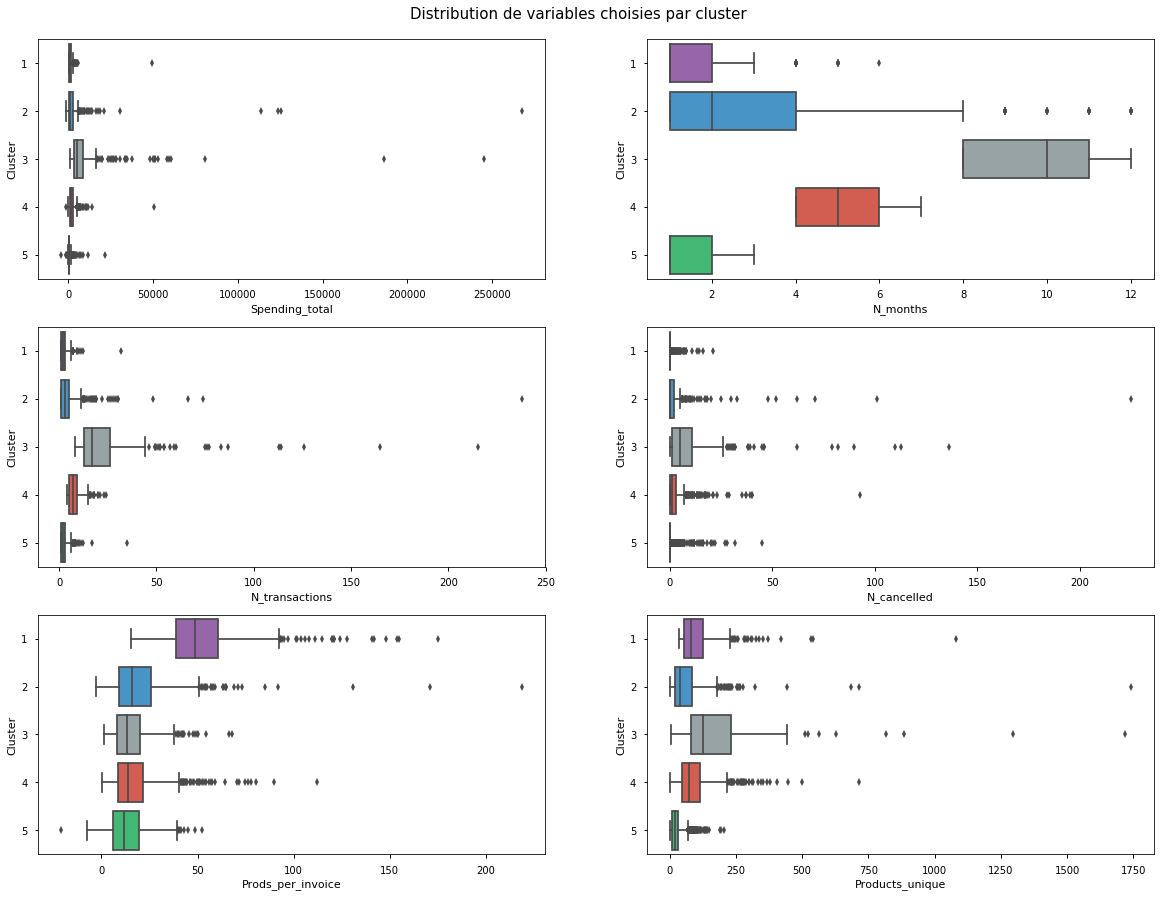

In [9]:
def display_boxplots(data, columns, title):
    f, axarr = plt.subplots(3, 2, figsize=(20, 15))
    i, j = 0, 0
    plt.suptitle(title, y=0.91, fontsize=15); 
    
    for col in columns:
        sns.boxplot(y='Cluster', x=col, data=data, orient='h', palette=rbg_colors, ax = axarr[i, j])
        j += 1
        if j > 1:
            j = 0
            i += 1

columns = ['Spending_total', 'N_months', 'N_transactions', 'N_cancelled', 'Prods_per_invoice', 'Products_unique']
data['Cluster'] = labels

display_boxplots(data, columns, 'Distribution de variables choisies par cluster')

D'après les descriptions statistiques ci-dessous, nous choisissons d'interpréter chaque cluster obtenu comme suit:
- **1 - 'Entreposeurs'** : Achètent des produits en grande quantité, mais faible diverisité, en peu de fois dans le temps.
- **2 - 'Internationaux'**: Clients hors du Royaume-Uni.
- **3 - 'Fidèles'**: Clients qui dépensent le plus, sur une longue durée et très régulièrement.
- **4 - 'Occasionnels'**: Achètent de temps à autres, pour des dépenses totales moyennes.
- **5 - 'One-timers'**: Classe plus peuplée. Achètent souvent très peu de fois, peu de produits différents et dépensent.

---
## Prédiction progressive des groupes par classification

Maintenant que nous avons segmenté notre base clients, nous allons nous servir de leur groupe d'appartenance comme variable cible dans une phase d'apprentissage supervisé.

Nous allons entrainer des modèles de classification afin de tenter prédire les groupe d'appartenance à partir des descripteurs. Puis, dans la phase d'évaluation des modèles, nous allons tenter de voir leur performance en prenant progressivement les achats faits au cours des *n* premiers mois de factures de chaque client pour créer synthétiquement les descripteurs (comme fait dans le notebook 'Exploration'), et ainsi voir à quelle point la durée de recueillement de données sur nos clients impacte la justesse de leur classification.

### Préparation des jeux de données

Séparons le du jeu de données initial en deux parties 
- une partie sur laquelle seront entrainés nos modèles (jeu d'entrainement),
- une autre sur laquelle nous allons tester la véracité des prédictions de nos modèles (jeu de test)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Cluster', axis=1), labels, 
                                                    train_size=0.7, test_size=0.3, 
                                                    random_state=0)

sorted_index = X_test.index.sort_values()
y_test = data.loc[sorted_index, 'Cluster']

Créons notre "Curseur temporel" qui nous servira à ne sélectionner que les factures des *n* premiers mois d'achats par client

In [11]:
cursor = purchases[['CustomerID', 'InvoiceNo', 'Month']].drop_duplicates()
cursor.loc[cursor.Month==12, 'Month'] = 0 # considers Dec. 2010 as the first month of recording

# Labels each invoice with nth month of buying for each customer
cursor['Nth_month'] = (cursor.groupby('CustomerID')['Month']
                      .rank(method='dense'))

Utilisons ce curseur pour créer 12 jeux de tests différents, sur lesquels seront évalués notre modèle.

In [12]:
test_purchases = purchases[purchases.CustomerID.isin(sorted_index)]
test_sets = []

for n in range(1, 13):
    current_invoices = cursor[cursor.Nth_month <= n].InvoiceNo
    current_purchases = test_purchases[test_purchases.InvoiceNo.isin(current_invoices)]
    current_features = transform_data(current_purchases)
    test_sets.append(current_features)

### Entrainer les modèles

Pour prendre en compte la diversité des méthodes de classification qui existe, nous avons tenter notre entrainement sur les méthodes suivantes:
- Régression Logistique
- Machine à Vecteurs de Support
- Forêt Aléatoire
- Perceptron Multi-couches

Pour chacune de ces méthodes, nous cherchons d'abord dans un espace d'hyperparamètres possibles la combinaison qui permet de maximiser le taux de classification global (_accuracy_). Ensuite, nous évaluons les performance de des prédictions de ces meilleurs modèles à l'aide d'un graphe d'évolution des taux de classification dans le temps par cluster, et aussi à l'aide d'une matrice de confusion.

Suivant le type de classifier, nous appliquons une phase de pré-processing si nécessaire ou non.

#### Régression Logistique

In [13]:
hyperparameters = {'penalty': ['l1', 'l2'], 
                   'C': [1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10, 30, 100]}
estimator_lr = LogisticRegression(max_iter=1e4, tol=1e-4)
grid_lr = GridSearchCV(estimator_lr, hyperparameters, scoring='accuracy', 
                       cv=10, iid=True, verbose=1)

grid_lr.fit(X_train, y_train)
results_lr = Classification_Results(grid_lr.best_estimator_, "Régression Logistique",
                                    test_sets, y_test, n_clusters)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  2.1min finished


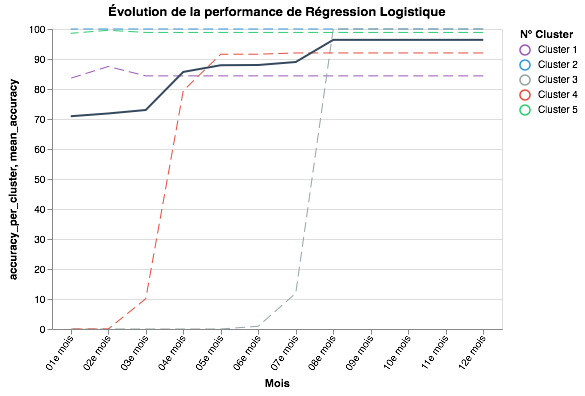

In [14]:
results_lr.graph_evolution()

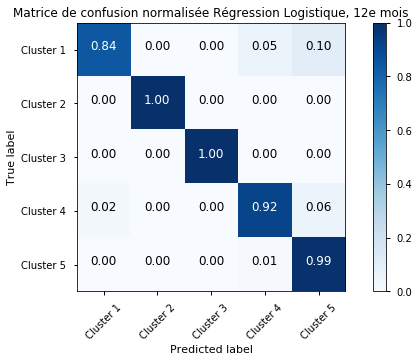

In [15]:
results_lr.confusion_matrix()

#### Machine à Vecteurs de Support

In [16]:
hyperparameters = {'svc__C': [1e-1, 3e-1, 1, 3, 10, 30, 100], 
                   'svc__kernel': ['rbf', 'linear']}

estimator_svc = Pipeline([('scaler', MinMaxScaler()), 
                          ('svc', SVC(gamma='auto', probability=True))])
grid_svc = GridSearchCV(estimator_svc, hyperparameters, scoring='accuracy',
                        cv=10, iid=True, verbose=1, n_jobs=-1)

grid_svc.fit(X_train, y_train)
results_svc = Classification_Results(grid_svc.best_estimator_, "SVM",
                                     test_sets, y_test, n_clusters)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   14.7s finished


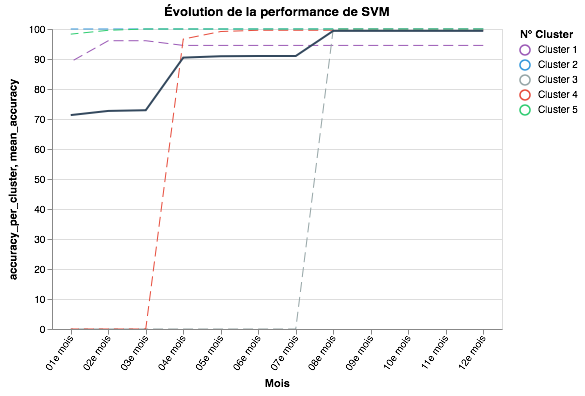

In [17]:
results_svc.graph_evolution()

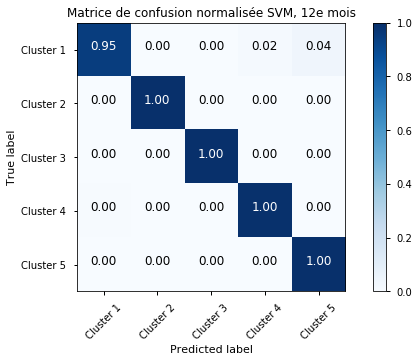

In [18]:
results_svc.confusion_matrix()

#### Forêt Aléatoire

In [19]:
hyperparameters = {'n_estimators': [10, 100, 1000], 
                   'criterion': ['gini', 'entropy'], 
                   'max_features': ['auto', 'sqrt', 'log2'], 
                   'min_samples_split': [2, 15, 30]}
estimator_rf = RandomForestClassifier()
grid_rf = GridSearchCV(estimator_rf, hyperparameters, scoring='accuracy',
                       cv=10, iid=True, verbose=1, n_jobs=-1)

grid_rf.fit(X_train, y_train)
results_rf = Classification_Results(grid_rf.best_estimator_, "Forêt Aléatoire",
                                    test_sets, y_test, n_clusters)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 503 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.0min finished


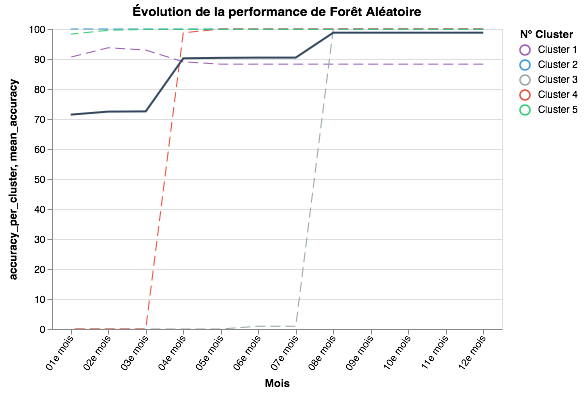

In [20]:
results_rf.graph_evolution()

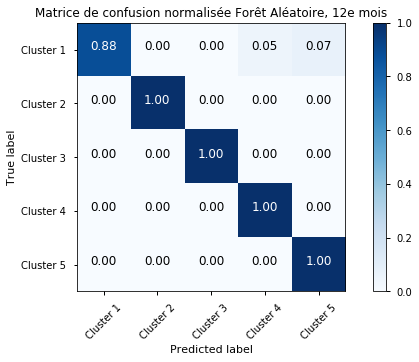

In [21]:
results_rf.confusion_matrix()

#### Perceptron Multicouches

In [22]:
hyperparameters = {'mlp__hidden_layer_sizes': [(5,), (10,), (25,), (50,), (100,), (150,)],
                   'mlp__activation': ['relu', 'logistic', 'tanh'],
                   'mlp__alpha': [1e-2, 3e-2, 1e-1, 3e-1, 0],}
estimator_mlp = Pipeline([('scaler', MinMaxScaler()), 
                          ('mlp', MLPClassifier(max_iter=10000, early_stopping=True))])
grid_mlp = GridSearchCV(estimator_mlp, hyperparameters, scoring='accuracy',
                       cv=10, iid=True, verbose=1, n_jobs=1)

grid_mlp.fit(X_train, y_train)
results_mlp = Classification_Results(grid_mlp.best_estimator_, "Perceptron Multicouches",
                                    test_sets, y_test, n_clusters)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  6.1min finished


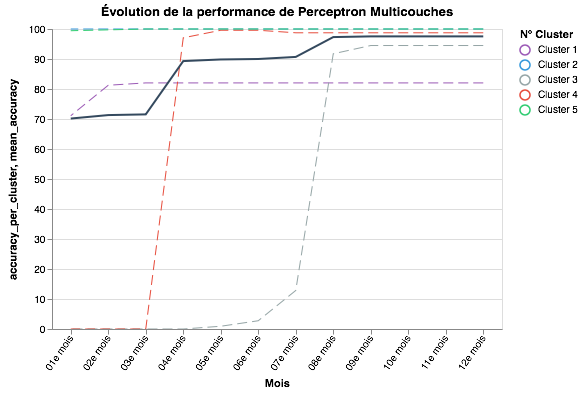

In [23]:
results_mlp.graph_evolution()

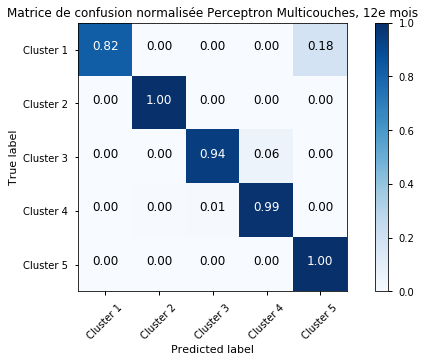

In [24]:
results_mlp.confusion_matrix()

### Interprétations et conclusions

Le meilleur classifieur est la Machine à Support de Vecteurs avec les hyperparamètres suivants

In [25]:
grid_svc.best_params_

{'svc__C': 30, 'svc__kernel': 'linear'}

Il approche les 100% de taux de classification sur l'ensemble des données, et réussi à correctement identifier toutes les instances de tous les clusters sauf 10% d'instances du `Cluster 1`.

Nous pouvons observer sur tous les graphiques d'évolution de performance que la classification de catégories est très convenable dès le début : les clusters des Entreposeurs et des Internationaux. En effet, les variables liéés à leurs caractéristiques principales (peu de produits, acheteurs ponctuels, hors du Royaume-Uni) sont déjà discriminantes.

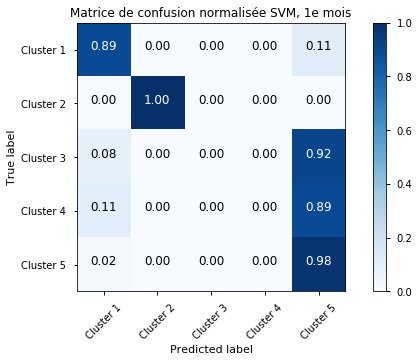

In [26]:
results_svc.confusion_matrix(n=0)

Cependant, pour les 3 autres clusters, nous observons une décantation progressive: les One-Timers englobent aussi les Occasionnels et Fidèles au départ. Au fur et à mesure que l'on prend en compte d'autres  mois de factures, alors on arrive à correctement classifier les acheteurs Occassionnels à partir du 4e mois

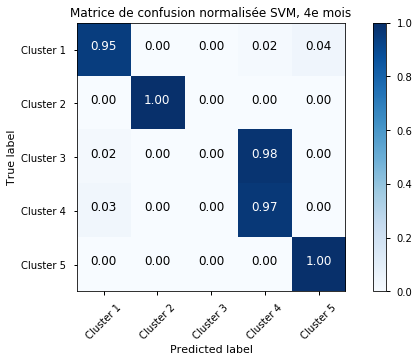

In [27]:
results_svc.confusion_matrix(n=3)

Enfin, au 8e mois, les Fidèles sont affectés au bon cluster. Cette décantation s'explique par le fait que plus de factures sont prises en compte, plus les valeurs des descripteurs créés à partir des achats considérés s'adaptent se rapprochent des valeurs discriminantes apprises par les modèles pour créer leurs frontières de décision.

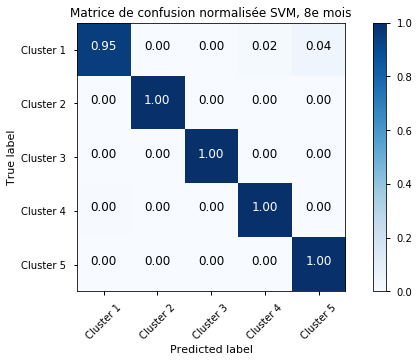

In [28]:
results_svc.confusion_matrix(n=7)

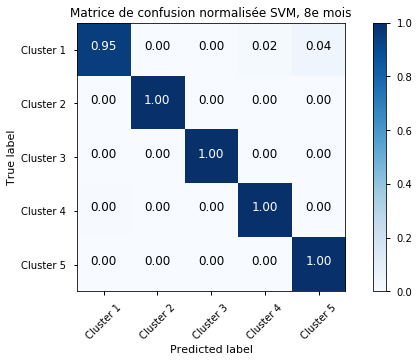

In [29]:
results_svc.confusion_matrix(n=7)

Pour finir, nous sauvegardons notre meilleur modèle afin de pouvoir l'utiliser dans notre programme `customer_classes` qui prend en entrée une série temporelle d'achats et prédit la classe d'appartenances des clients.

In [30]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(grid_svc.best_estimator_, f)